### Experiment with Copia module: book genres
This notebook explores the data on the survival of poetic books (1834-1850) stored in 10 library collections; books are manually provided with general genre tags, the groups are:
- col_lyr: poetry collections of lyrical texts (short poems);
- col_nar: colletcions of narrative poems (~epic poetry);
- sep_lyr: separate issues of one lyrical text (one-two pages brochures with a single poem);
- sep_nar: separate issues of one narrative poem;
- sep_drama: separate issue of a dramatic text in verse;
- alm_ : almanacs and collective issues (may also include prose);

#### Part I: Tests for each book genre for the whole period (1834-1850)

In [1]:
import os
import glob

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np
np.random.seed(1234)

In [2]:
import copia.utils as u
from copia.richness import *

from copia.utils import survival_ratio
from copia.utils import to_abundance, basic_stats

from copia.richness import species_accumulation

from copia.plot import abundance_histogram, accumulation_curve, multi_kde, survival_errorbar

In [3]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['ytick.minor.left'] = False

In [33]:
groups = {}
df = None

# import all separate .csv tables for the experiment as a dictionary of tables

for fh in sorted(glob.glob('../data/copia_experiment/*.csv')):
    df = pd.read_csv(fh)
    df = df.iloc[:,1:]
    genre = os.path.basename(fh).replace('.csv','').replace('_', ' ')
    groups[genre] = df[['work', 'collection']]

In [34]:
groups

{'Almanacks':                                                   work collection
 0    1834_43_Фл… Спин.._Незабудка: Московский Альма...        nlr
 1    1834_43_Фл… Спин.._Незабудка: Московский Альма...        rsl
 2    1834_43_Фл… Спин.._Незабудка: Московский Альма...      fi_sl
 3    1834_47_Максимович М._Денница: Альманах на 183...        nlr
 4    1834_47_Максимович М._Денница: Альманах на 183...      fi_sl
 ..                                                 ...        ...
 303  1830_981_NA_Чертополох, карманная книжица для ...        nlr
 304  1830_981_NA_Чертополох, карманная книжица для ...        rsl
 305  1830_981_NA_Чертополох, карманная книжица для ...      spbgu
 306  1830_1027_NA_Старинные диковинки, или собрание...        nlr
 307  1830_1027_NA_Старинные диковинки, или собрание...      fi_sl
 
 [308 rows x 2 columns],
 'Collections lyric':                                                   work  collection
 0    1834_2_Батюшков К._Сочинения в прозе и стихах ...         nlr

In [35]:
# Basic stats calculation

stats = []

for genre, df in groups.items():
    abundance = u.to_abundance(df['work']) # convert to abundance data
    s = u.basic_stats(abundance) # basic stats function
    d = {'Group': genre}
    # take f3 and f4 for well-survived groups
    for k in ('f1', 'f2', 'f3', 'f4', 'S', 'n'):
        d[k] = s[k]
    d['Collections'] = len(set(df['collection']))
    stats.append(d)
    
# Conversion to df for easier use
stats_df = pd.DataFrame(stats)
stats_df

,Group,f1,f2,f3,f4,S,n,Collections
0,Almanacks,6,26,41,16,101,308,9
1,Collections lyric,64,68,57,54,313,1000,11
2,Collections narrative,2,5,2,8,27,108,10
3,Separate lyric,188,56,15,8,269,387,11
4,Separate narrative,69,72,60,31,257,659,11


Almanacks
Collections lyric
Collections narrative
Separate lyric
Separate narrative


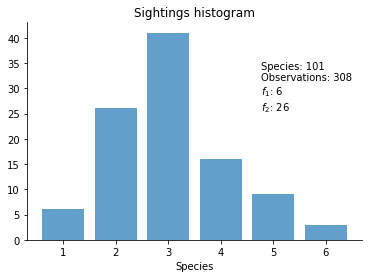

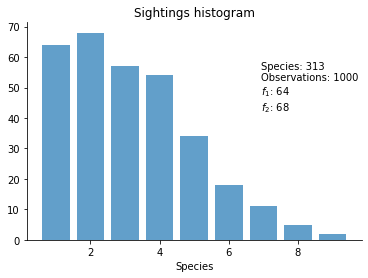

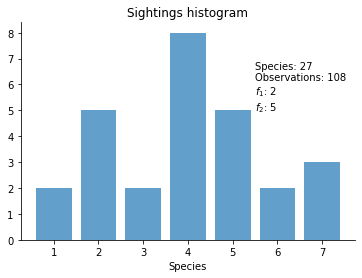

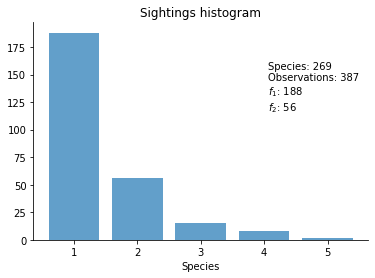

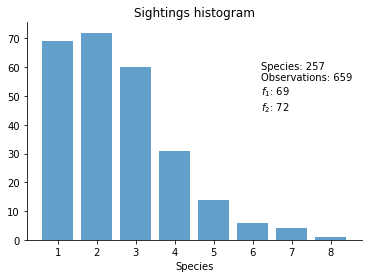

In [36]:
# fast viz: sightings hist

for genre, df in groups.items():
    abundance = u.to_abundance(df['work'])
    print(genre)
    abundance_histogram(abundance)

In [37]:
# Estimations for original works with different estimators

estimation_dict = {}

for genre, df in groups.items():
    abundance = u.to_abundance(df['work'])
    estimation_dict[genre.title()] = abundance

for genre, population in estimation_dict.items():
    print('genre:', genre)
    for m in ('chao1', 'ichao1', 'egghe_proot'):
        print(' - ', m, '->', diversity(population, method = m))

genre: Almanacks
 -  chao1 -> 101.69005994005994
 -  ichao1 -> 101.69005994005994
 -  egghe_proot -> 101.02095891738362
genre: Collections Lyric
 -  chao1 -> 343.0875294117647
 -  ichao1 -> 350.5057392883079
 -  egghe_proot -> 355.4937603040866
genre: Collections Narrative
 -  chao1 -> 27.396296296296295
 -  ichao1 -> 27.482233796296295
 -  egghe_proot -> 27.19243329141031
genre: Separate Lyric
 -  chao1 -> 583.7559985234404
 -  ichao1 -> 647.2716235234404
 -  egghe_proot -> 597.2595412883953
genre: Separate Narrative
 -  chao1 -> 290.01232928679815
 -  ichao1 -> 290.01232928679815
 -  egghe_proot -> 293.4242222910879


In [38]:
# Minimum additional sample (lower bound on the true population size)

for genre, population in estimation_dict.items():
    print('genre:', genre)
    print(' - works : ', diversity(population, method = 'ichao1')) # ichao1 for taking into acc. f3 & f4
    print(' - documents : ', diversity(population, method = 'minsample'))

genre: Almanacks
 - works :  101.69005994005994
 - documents :  406.12889812889813
genre: Collections Lyric
 - works :  350.5057392883079
 - documents :  3927.002927002927
genre: Collections Narrative
 - works :  27.482233796296295
 - documents :  144.1908361908362
genre: Separate Lyric
 - works :  647.2716235234404
 - documents :  6021.919134919135
genre: Separate Narrative
 - works :  290.01232928679815
 - documents :  2654.915295915296


/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:424: RuntimeWarning: overflow encountered in exp
  v = lambda x: np.exp(x * (2 * f2 / f1))
/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13672695360946818 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


In [44]:
# Survival ratios on density plot: works

works_survival = {}
for genre, population in estimation_dict.items():
    works_survival[genre] = survival_ratio(population, method = 'ichao1')

  0%|                                          | 1/1000 [00:01<17:27,  1.05s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<17:31,  1.05s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 824.07it/s]


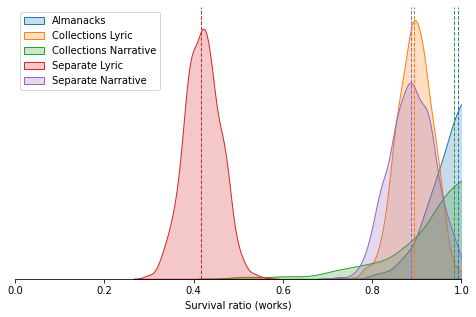

In [45]:
surv_density_works = multi_kde(works_survival)
surv_density_works.set_xlabel('Survival ratio (works)')
surv_density_works.set_yticklabels([])
surv_density_works.tick_params(axis = 'y', which = 'both', left = False)
surv_density_works.spines['left'].set_visible(False)

figure = plt.gcf() 
figure.set_size_inches(8, 5)
plt.savefig("../plots/01_work_surv_density.jpeg", dpi = 300)

### Accumulation curves
- Lowest survival: 
    - Separate lyric poems
    - Separate narrative poems
    - Collections of lyric poems

100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.23it/s]


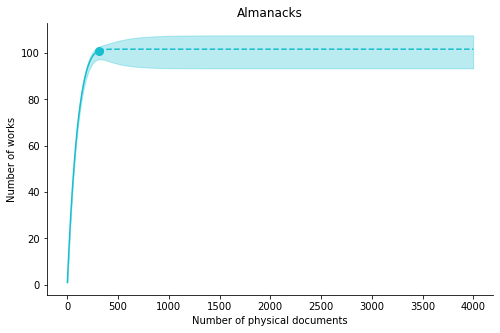

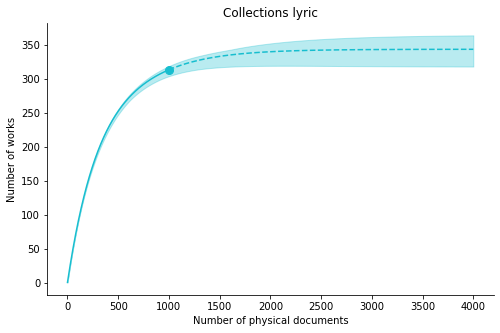

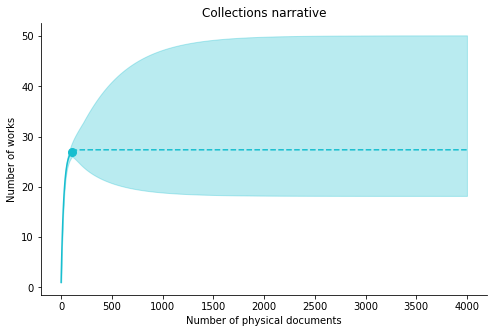

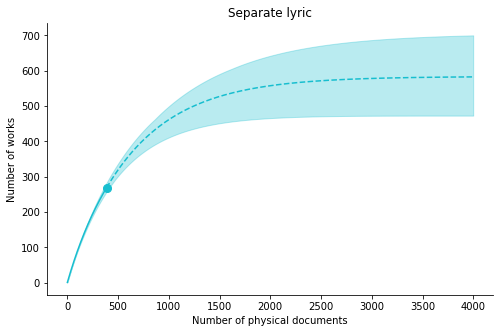

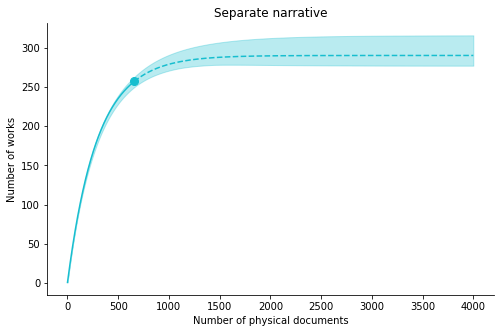

In [47]:
# accumulation curves

for genre, df in groups.items():
    abundance = u.to_abundance(df['work'])
    accumulation = species_accumulation(abundance, max_steps = 4000, n_iter = 10)
    accumulation_curve(abundance, accumulation, 
                       xlabel = 'Number of physical documents', ylabel = 'Number of works',
                       title = genre, 
                       c0 = 'C9')
    plt_name = '../plots/02_'+genre+'.jpeg'
    
    figure = plt.gcf() 
    figure.set_size_inches(8, 5)
    plt.savefig(plt_name, dpi = 300)

#### Comparison of different estimators (works)

In [48]:
comp = []

for estim in ['chao1', 'ichao1', 'egghe_proot']:
    for genre, population in estimation_dict.items():
        surv = survival_ratio(population, method = estim, n_iter = 1000)
        comp.append([genre, estim, surv['survival'], surv['lci'], surv['uci']])

  0%|                                          | 1/1000 [00:01<17:21,  1.04s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<17:35,  1.06s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:185: UserWarning: Add-one smoothing for P2 = 0
  warnings.warn("Add-one smoothing for P2 = 0", UserWarning)
100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 829.61it/s]


In [49]:
comp_df = pd.DataFrame(comp, columns = ['genre', 'estimator', 'survival_ratio', 'lower_ci', 'upper_ci'])

estimates = comp_df.sort_values(['genre', 'estimator'])
estimates

,genre,estimator,survival_ratio,lower_ci,upper_ci
0,Almanacks,chao1,0.993214,0.890111,1.087568
10,Almanacks,egghe_proot,0.999793,0.783059,1.153762
5,Almanacks,ichao1,0.993214,0.872300,1.100082
1,Collections Lyric,chao1,0.912304,0.844669,0.975587
11,Collections Lyric,egghe_proot,0.880466,0.759151,0.997006
6,Collections Lyric,ichao1,0.892995,0.818155,0.971618
2,Collections Narrative,chao1,0.985535,0.720515,1.165238
12,Collections Narrative,egghe_proot,0.992923,0.424558,1.497863
7,Collections Narrative,ichao1,0.982453,0.700513,1.196818
3,Separate Lyric,chao1,0.460809,0.380035,0.547307


### Fast test: time differences for genres

In [50]:
groups_t = {}
df_t = None

# import all separate .csv tables for the experiment as a dictionary of tables

for fh in sorted(glob.glob('../data/copia_experiment/addition/*.csv')):
    df_t = pd.read_csv(fh)
    df_t = df_t.iloc[:,1:]
    genre = os.path.basename(fh).replace('.csv','').replace('exp_','').lower()
    groups_t[genre] = df_t[['work', 'collection']]

In [51]:
groups_t

{'almanack 1830':                                                   work collection
 0    43_Фл… Спин.._Незабудка: Московский Альманах. ...        nlr
 1    43_Фл… Спин.._Незабудка: Московский Альманах. ...        rsl
 2    43_Фл… Спин.._Незабудка: Московский Альманах. ...      fi_sl
 3       47_Максимович М._Денница: Альманах на 1834 год        nlr
 4       47_Максимович М._Денница: Альманах на 1834 год      fi_sl
 ..                                                 ...        ...
 117  981_NA_Чертополох, карманная книжица для любит...        nlr
 118  981_NA_Чертополох, карманная книжица для любит...        rsl
 119  981_NA_Чертополох, карманная книжица для любит...      spbgu
 120  1027_NA_Старинные диковинки, или собрание прос...        nlr
 121  1027_NA_Старинные диковинки, или собрание прос...      fi_sl
 
 [122 rows x 2 columns],
 'almanack 1835':                                                  work  collection
 0   97_NA_Весенние цветы, или Собрание романсов, б...         nlr
 

In [52]:
# Basic stats calculation

stats_t = []

for genre, df in groups_t.items():
    abundance = u.to_abundance(df['work']) # convert to abundance data
    s = u.basic_stats(abundance) # basic stats function
    d = {'group': genre}
    # take f3 and f4 for well-survived groups
    for k in ('f1', 'f2', 'f3', 'f4', 'S', 'n'):
        d[k] = s[k]
    d['lib'] = len(set(df['collection']))
    stats_t.append(d)
    
# Conversion to df for easier use
stats_t_df = pd.DataFrame(stats_t)
stats_t_df

,group,f1,f2,f3,f4,S,n,lib
0,almanack 1830,3,14,20,4,44,122,7
1,almanack 1835,0,5,5,7,18,59,7
2,almanack 1840,2,3,7,0,20,71,8
3,almanack 1845,1,4,9,5,19,56,6
4,collections lyric 1830,9,19,15,17,85,321,11
5,collections lyric 1835,19,22,13,10,90,293,11
6,collections lyric 1840,15,14,9,13,66,201,10
7,collections lyric 1845,21,13,20,14,72,185,8
8,collections narrative 1830,1,1,1,2,7,26,9
9,collections narrative 1835,1,1,1,3,14,64,10


In [72]:
populations_t = {}

for genre, df in groups_t.items():
    abundance = u.to_abundance(df_t['work'])
    populations_t[genre.title()] = abundance
    
wsurvival_t = {}

for genre, population in populations_t.items():
    wsurvival_t[genre] = survival_ratio(population, method = 'ichao1')

/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<22:22,  1.34s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<17:41,  1.06s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<17:49,  1.07s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          |

In [73]:
#keys = {'Almanac_1830', 'Almanac_1835', 'Almanac_1840', 'Almanac_1840'}
keys = {'Collections Lyric 1830', 'Collections Lyric 1835', 
        'Collections Lyric 1840', 'Collections Lyric 1845'}

wt = [wsurvival_t]

l = [{k:v for k, v in i.items() if k in keys} for i in wt]
l = l[0]

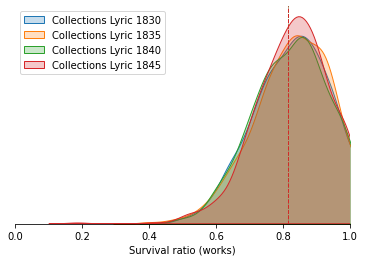

In [74]:
surv_density_w_t = multi_kde(l)
surv_density_w_t.set_xlabel('Survival ratio (works)')
surv_density_w_t.set_yticklabels([])
surv_density_w_t.tick_params(axis = 'y', which = 'both', left = False)
surv_density_w_t.spines['left'].set_visible(False)

plt.savefig("../plots/03_surv_density_periods_cl.jpeg", dpi = 300)

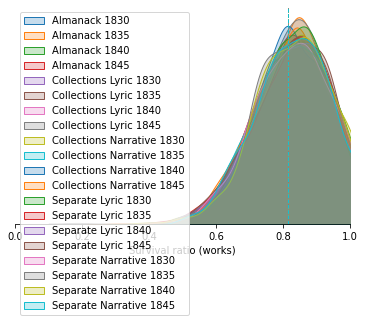

In [85]:
# keys = {}

# keys = {'Collections Lyric 1830'}

# l = [{k:v for k, v in i.items() if k in keys} for i in wt]
# l = l[0]

surv_density_w_t = multi_kde(wsurvival_t)
surv_density_w_t.set_xlabel('Survival ratio (works)')
surv_density_w_t.set_yticklabels([])
surv_density_w_t.tick_params(axis = 'y', which = 'both', left = False)
surv_density_w_t.spines['left'].set_visible(False)


plt.savefig("../plots/03_surv_density_periods_sl.jpeg", dpi = 300)

In [76]:
wt

[{'Almanack 1830': {'survival': 0.8163970209040429,
   'bootstrap': array([0.606029  , 0.90454618, 0.69187871, 0.64288119, 0.95206344,
          0.73289622, 0.64780153, 0.85529604, 1.00620944, 0.66405943,
          0.83241704, 0.83569955, 0.73118798, 0.83075446, 0.89016098,
          0.84831035, 0.7346363 , 0.77590896, 0.69689624, 0.56975118,
          0.97010095, 0.83181908, 0.81946722, 0.79695774, 0.75395946,
          0.92824176, 0.78885106, 0.98782176, 1.00352606, 0.81212298,
          0.75396706, 0.7049645 , 1.04429226, 0.59094061, 0.71361503,
          0.85317951, 0.93917263, 0.85322435, 0.938121  , 0.88519215,
          1.02188017, 0.94918729, 0.88330566, 0.94954838, 0.69032366,
          0.91095448, 0.76512889, 0.90291665, 0.54623473, 1.17312894,
          0.91718969, 0.71278332, 0.59842502, 0.93336718, 0.82779352,
          0.74712821, 0.81503673, 0.95301139, 0.85982891, 0.57735661,
          0.95112539, 0.91239035, 0.66528483, 0.95869967, 0.73116751,
          1.05781078, 0.5

In [78]:
l

{'Almanack 1830': {'survival': 0.8163970209040429,
  'bootstrap': array([0.606029  , 0.90454618, 0.69187871, 0.64288119, 0.95206344,
         0.73289622, 0.64780153, 0.85529604, 1.00620944, 0.66405943,
         0.83241704, 0.83569955, 0.73118798, 0.83075446, 0.89016098,
         0.84831035, 0.7346363 , 0.77590896, 0.69689624, 0.56975118,
         0.97010095, 0.83181908, 0.81946722, 0.79695774, 0.75395946,
         0.92824176, 0.78885106, 0.98782176, 1.00352606, 0.81212298,
         0.75396706, 0.7049645 , 1.04429226, 0.59094061, 0.71361503,
         0.85317951, 0.93917263, 0.85322435, 0.938121  , 0.88519215,
         1.02188017, 0.94918729, 0.88330566, 0.94954838, 0.69032366,
         0.91095448, 0.76512889, 0.90291665, 0.54623473, 1.17312894,
         0.91718969, 0.71278332, 0.59842502, 0.93336718, 0.82779352,
         0.74712821, 0.81503673, 0.95301139, 0.85982891, 0.57735661,
         0.95112539, 0.91239035, 0.66528483, 0.95869967, 0.73116751,
         1.05781078, 0.53455268, 0.9535